In [ ]:
%cd /content/drive/MyDrive/4조/2.데이터

/content/drive/.shortcut-targets-by-id/1t5JFoUpndxpFtZ957fKqxENUgFJ7lTNo/4조/2.데이터


In [ ]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import cv2, math, warnings
import matplotlib.pyplot as plt
import mediapipe as mp
import numpy as np
warnings.filterwarnings('ignore')

## 0.Media Pipe 적용

In [ ]:
def find_point(image):    
    max_num_hands = 1

    mp_hands = mp.solutions.hands
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    drawing_spec = mp_drawing.DrawingSpec(thickness=50, circle_radius=20)

    hands = mp_hands.Hands(
        max_num_hands=max_num_hands,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5)

    cap = cv2.VideoCapture(0)
    img_copy = image.copy()
    result = hands.process(img_copy)

    if result.multi_hand_landmarks is not None:
        index = 1 - result.multi_handedness[0].classification[0].index
        for res in result.multi_hand_landmarks:
            joint = np.zeros((21, 3))
            for j, lm in enumerate(res.landmark):
                joint[j] = [lm.x, lm.y, lm.z]

            if len(joint) == 21:
                h, w, c = img_copy.shape
                point = joint * [w, h, c]

                # 관절의 각도를 계산하기 위한 vector
                v1 = joint[[0,1,2,3,0,5,6,7,0,9,10,11,0,13,14,15,0,17,18,19],:] # Parent joint
                v2 = joint[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],:] # Child joint
                v = v2 - v1 # [20,3]
                # Normalize v
                v = v / np.linalg.norm(v, axis=1)[:, np.newaxis]

                # Get angle using arcos of dot product
                angle = np.arccos(np.einsum('nt,nt->n',
                        v[[0,1,2,4,5,6,8,9,10,12,13,14,16,17,18],:], 
                        v[[1,2,3,5,6,7,9,10,11,13,14,15,17,18,19],:])) # [15,] 

                angle = np.degrees(angle) # Convert radian to degree

                # Inference gesture
                data = np.array([angle], dtype=np.float32)
        
                mp_drawing.draw_landmarks(img_copy, res, mp_hands.HAND_CONNECTIONS, 
                                        mp_drawing.DrawingSpec(color=(112, 146, 190), thickness=20, circle_radius=10), 
                                        mp_drawing.DrawingSpec(color=(153, 217, 234), thickness=20, circle_radius=10))
                return img_copy, point, index
            
            else:
                print('손을 가운데에 위치시켜주세요.')
                break
    
    else:
        print('손을 가운데에 위치시켜주세요.')
# 163,73,164 / 200,191,231

## 1.이미지 자르기
- A(손끝), B(첫 번째 관절), C(두 번째 관절), D(세 번째 관절)
- grad : 손가락의 기울기
- center  : A와 B의 중심
- dist  : A와 B 사이의 거리

In [ ]:
def rotation_finger(img, point):
    plt.figure(figsize=(15, 6))
    for num, idx in enumerate(range(4,21,4)):
        A = point[idx]; B = point[idx-1]; C = point[idx-2]; D = point[idx-3]

        center = ((A[0]+B[0])/2, (A[1]+B[1])/2)             # 중심 좌표 계산
        dist = ((A[1]-B[1])**2 + (A[0]-B[0])**2)**(1/2)     # 피타고라스 정리
        rad = math.atan2(A[1] - D[1],A[0] - D[0] )
        degree = 90+(rad*180)/ math.pi

        # 이미지 회전
        img_copy = img.copy()
        matrix = cv2.getRotationMatrix2D(center, degree, scale=1)
        img_copy = cv2.warpAffine(img_copy, matrix, (img_copy.shape[1], img_copy.shape[0]))
        plt.subplot(2, 5, num+1);
        plt.axis('off')
        plt.imshow(img_copy)       


        # 자르기 영역
        pt_x1 = int(center[0] - dist*0.7)
        pt_y1 = int(center[1] - dist*1.5)
        pt_x2 = int(center[0] + dist*0.7)
        pt_y2 = int(center[1] + dist*0.8)
        
        if pt_x1 < 0 :
            pt_x1 = 0
        if pt_x2 > img.shape[0]:
            pt_x2 = img.shape[0]

        print(pt_y1, pt_y2, pt_x1, pt_x2)

        globals()['img{}'.format(num)] = img_copy[pt_y1:pt_y2, pt_x1:pt_x2]             # [y범위, x범위]
        print(globals()['img{}'.format(num)].shape)

        plt.subplot(2, 5, 5+num+1)
        plt.axis('off')
        plt.imshow(globals()['img{}'.format(num)]);

1


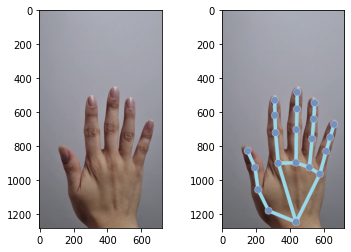

In [ ]:
image = cv2.imread("./손이미지/손_550.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

img, point, index = find_point(image)
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(img);
print(index)

715 962 96 246
(247, 150, 3)
441 645 246 370
(204, 124, 3)
384 610 370 508
(226, 138, 3)
450 669 473 606
(219, 133, 3)
590 773 588 699
(183, 111, 3)


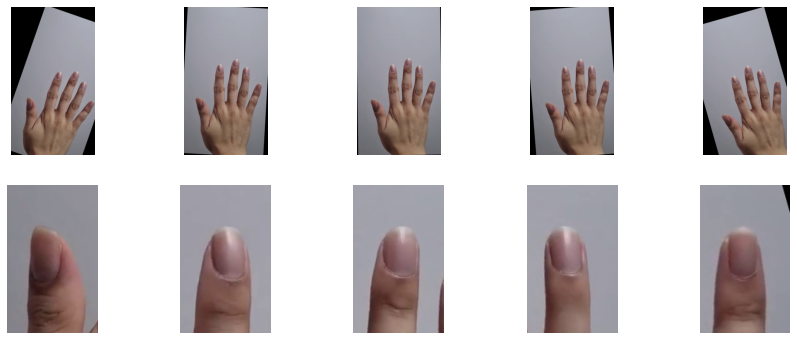

In [ ]:
rotation_finger(image, point)

## 2.피부영역검출
1. cv2.COLOR_BGR2YCrCb -> cv2.inRange
2. cv2.COLOR_BGR2HSV -> cv2.inRange
3. 히스토그램 역투영
- 잡음 제거 전후 비교할것.

### 2.1. YCrCb -> cv2.inRange 

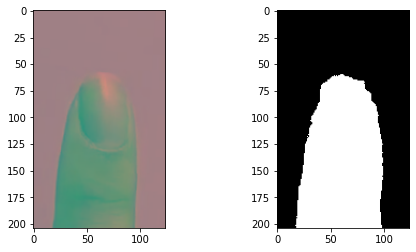

In [ ]:
ycc1 = cv2.cvtColor(img1, cv2.COLOR_RGB2YCrCb)
mask_hand1 = cv2.inRange(ycc1, np.array([0, 133, 77]), np.array([255, 173, 127]))

plt.figure(figsize = (8, 4))
plt.subplot(1, 2, 1)
plt.imshow(ycc1)
plt.subplot(1, 2, 2)
plt.imshow(mask_hand1, cmap = 'gray');

### 2.2 cv2.COLOR_BGR2HSV -> cv2.inRange

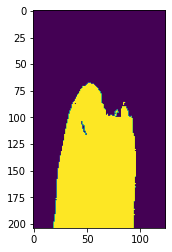

In [ ]:
hsv1 = cv2.cvtColor(img1, cv2.COLOR_BGR2HSV)
plt.imshow(hsv1);
lower = np.array([0,50, 80], dtype="uint8")
upper = np.array([180, 255,255], dtype="uint8")
img_hand = cv2.inRange(hsv1, lower, upper)
plt.imshow(img_hand);

### 2.3.히스토그램 역투영

In [ ]:
mask = cv2.imread('./손_125_마스크.jpg', cv2.IMREAD_GRAYSCALE)
ref = cv2.imread('./손이미지/손_125.jpg', cv2.IMREAD_COLOR)

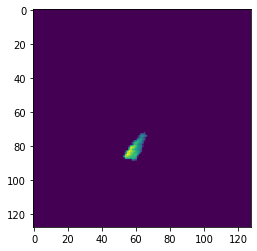

In [ ]:
ref_ycc = cv2.cvtColor(ref, cv2.COLOR_BGR2YCrCb)

# 히스토그램 생성
channels = [1, 2]       # Cr, Cb 손성만 이용
ranges = [0, 222, 0, 256]
hist = cv2.calcHist([ref_ycc], channels, mask, [128, 128], ranges)

hist_norm = cv2.normalize(cv2.log(hist + 1), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
plt.imshow(hist_norm);
plt.imsave('/content/hist_norm.jpg', hist_norm)

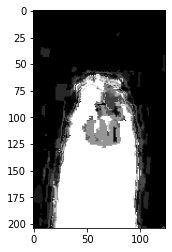

In [ ]:
# 히스토그램 역투영 적용
hist_img1 = cv2.calcBackProject([ycc1], channels, hist, ranges, 1)
plt.imshow(hist_img1, cmap = 'gray')

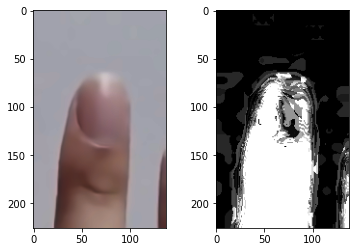

In [ ]:
# 이미지 blur 처리 후 역투영
denois2 = cv2.fastNlMeansDenoisingColored(img2, None, 10, 10, 5, 8)
plt.subplot(1, 2, 1)
plt.imshow(img2)
plt.imshow(denois2)

plt.subplot(1, 2, 2)
de_ycc1 = cv2.cvtColor(denois2, cv2.COLOR_RGB2YCrCb)
hist_img2 = cv2.calcBackProject([de_ycc1], channels, hist, ranges, 1)
plt.imshow(hist_img2, cmap = 'gray')

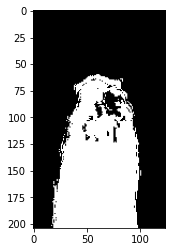

In [ ]:
ret, mask_img1 = cv2.threshold(hist_img1, 100, 255, cv2.THRESH_BINARY)
plt.imshow(mask_img1, cmap='gray');

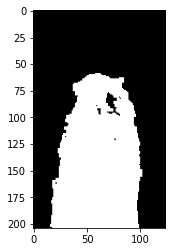

In [ ]:
# kennel 생성 - 사각형 5*5
kennel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
dst = cv2.dilate(mask_img1, kennel)            # 팽창 연산
# erosion = cv2.erode(dst, kennel)            # 침식 연산
plt.imshow(dst, cmap='gray');

### 손가락 영역 최대 길이 구하기

In [ ]:
max_len = 0
for row in dst:
    row_len = list(row).count(255)
    if row_len > max_len:
        max_len = row_len
print(max_len)

83


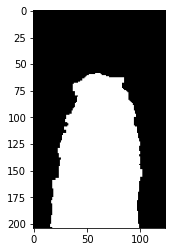

In [ ]:
for i, row in enumerate(dst):
    for j in range(1,len(row)-1):
        if row[j-1] == 255 and row[j] != 255 and (255 in row[j+1:]):
            dst[i][j] = 255
plt.imshow(dst, cmap='gray');

## 3.손톱영역검출
- 손가락영역은 2.1.1을 사용 (mask_hand)
- 손가락 영역에서 대비 증가
    - cv2.createCLAHE()
    - cv2.equalizeHist()
- 손가락 에지 검출
    - 로버츠 : 계산이 빠름
    - 소벨 : 뚜렷함
    - 프리윗 : 소벨보다 빠르고 로버츠보다 좋은 성능
- 임계값 조정 (8 ~ 12.5%, 9.5 ~ 10%)

### 3.1. 손가락(컬러이미지)에서 mask_hand영역만 가져오기

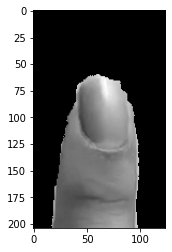

In [ ]:
masked1 = cv2.bitwise_and(img1, img1, mask=mask_hand1)
masked1 = cv2.cvtColor(masked1, cv2.COLOR_RGB2GRAY)
plt.imshow(masked1, cmap='gray');

### 3.2. 이미지 대비 높이기

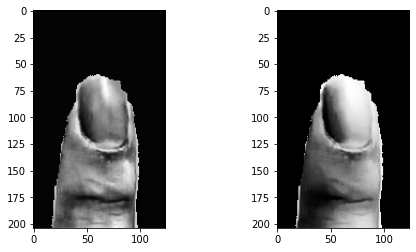

In [ ]:
# 대비 증가
# 방법1
clahe = cv2.createCLAHE(clipLimit =8.0, tileGridSize=(8, 8))
cla_img1 = clahe.apply(masked1)

# 방법2
hist_img1 = cv2.equalizeHist(masked1)

plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
plt.imshow(cla_img1, cmap = 'gray');
plt.subplot(1,2,2)
plt.imshow(hist_img1, cmap = 'gray');

### 3.3. edge검출

CPU times: user 23 µs, sys: 3 µs, total: 26 µs
Wall time: 30.3 µs
CPU times: user 0 ns, sys: 27 µs, total: 27 µs
Wall time: 29.6 µs


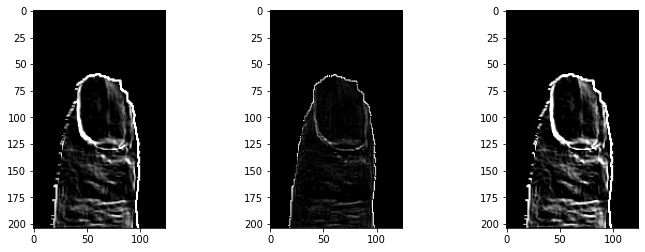

In [ ]:
# 소벨 에지 검출
roberts_x = np.array([[-1, 0, 0], [0, 1, 0], [0, 0, 0]])
roberts_y = np.array([[0, 0, -1], [0, 1, 0], [0, 0, 0]])

prewitt_x = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])
prewitt_y = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])

sobel_x = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
sobel_y = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])

roberts_x = cv2.convertScaleAbs(cv2.filter2D(cla_img1, -1, roberts_x))
roberts_y = cv2.convertScaleAbs(cv2.filter2D(cla_img1, -1, roberts_y))

prewitt_x = cv2.convertScaleAbs(cv2.filter2D(cla_img1, -1, prewitt_x))
prewitt_y = cv2.convertScaleAbs(cv2.filter2D(cla_img1, -1, prewitt_y))

sobel_x = cv2.convertScaleAbs(cv2.filter2D(cla_img1, -1, sobel_x))
sobel_y = cv2.convertScaleAbs(cv2.filter2D(cla_img1, -1, sobel_y))

%time prewitt = cv2.addWeighted(prewitt_x, 1, prewitt_y, 1, 0)
roberts = cv2.addWeighted(roberts_x, 1, roberts_y, 1, 0)
%time  sobel = cv2.addWeighted(sobel_x, 1, sobel_y, 1, 0)

plt.figure(figsize = (12, 4))
plt.subplot(1, 3, 1)
plt.imshow(prewitt, cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(roberts, cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(sobel, cmap='gray');

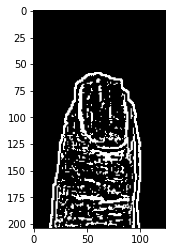

In [ ]:
th = cv2.adaptiveThreshold(cla_img1, 255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV, 5, 5)
plt.imshow(th, cmap='gray');

- 중앙을 기준으로 50~80%영역에 손톱이 있다고 제한.


In [ ]:
# 손톱 길이 구하기
lst = []
max_len = 0
for row in mask_hand1:
    sub_lst = []
    pre = 0
    for i,j in enumerate(row):
        if j == 255 and pre == 0:
            pre = 255
            sub_lst.append(i)
        elif j == 0 and pre == 255:
            pre = 0
            sub_lst.append(i)
    lst.append(sub_lst)

for idx, val in enumerate(lst):
    if len(val) >= 2:
        lenght = val[1] - val[0]
        if lenght > max_len:
            max_len = lenght

end = 0
while len(lst[end]) == 0:
    end += 1

print(max_len, end)     # 손가락 영역 길이,손 끝점+1

81 60


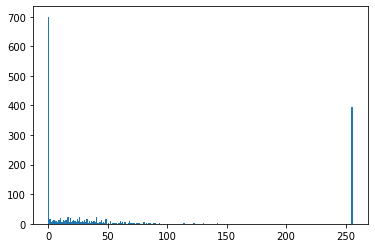

In [ ]:
ct = len(sobel[0])//2
area50 = max_len/2 * 0.5; area60 = max_len/2 * 0.6;area80 = max_len/2 * 0.8
x1 = int(ct - area80); x2 = int(ct - area50)
x3 = int(ct + area80); x4 = int(ct + area50)

sobel_left = sobel[end-1:, x1:x2]
hist_left = cv2.calcHist([sobel_left], [0], None, [256], [0, 256])
thresh1 = (hist_left.mean() + 255) / 2        # 임계값 1
plt.hist(sobel_left.ravel(), 256, [0, 256]);

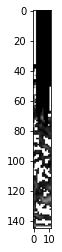

In [ ]:
# 수직 투영 그래프
h, w = sobel_left.shape

b = [0 for z in range(0, w)]

for i in range(0, w):
    for j in range(0, h):
        if sobel_left[j, i] == 0:
            b[i] += 1
            sobel_left[j, i] = 255

for i in range(0, w):
    for j in range(0, b[i]):
        sobel_left[j, i] = 0

plt.imshow(sobel_left, cmap='gray');

2

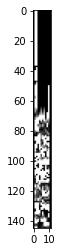

In [ ]:
# 수직투영 마스크
sobel_x = cv2.Sobel(sobel_left, cv2.CV_64F, 1, 0, ksize = 3)
sobel_X = cv2.convertScaleAbs(sobel_x)
plt.imshow(sobel_X, cmap='gray');

hist_left = cv2.calcHist([sobel_X], [0], None, [256], [0, 256])
th_left = (hist_left.mean() + 255)  / 2
ret, wh_left = np.where(sobel_X > th_left)
len(wh_left)

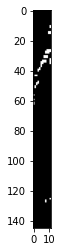

In [ ]:
# sobel_left에서 임계값1 보다 큰 값
ret, left1 = cv2.threshold(sobel_left, thresh1, 255, cv2.THRESH_BINARY)
plt.imshow(left1, cmap='gray')

(48, 109)

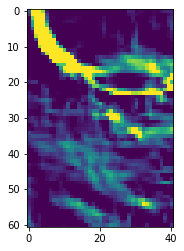

In [ ]:
y_13 = int(round(left1.shape[0] * (1/3),0)); y_34 = int(round(left1.shape[0] * (3/4),0))
left11 = sobel_left[y_13:y_34, :]
plt.imshow(left11)
y_13, y_34

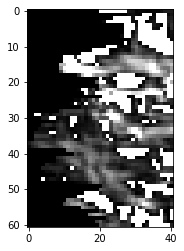

In [ ]:
# 수평 투영 그래프
h, w = left11.shape
a = [0 for z in range(0, h)]
for i in range(0, h):
    for j in range(0, w):
        if left11[i, j] == 0:
            a[i] += 1
            left11[i, j] = 255

for i in range(0, h):
    for j in range(0, a[i]):
        left11[i, j] = 0

plt.imshow(left11, cmap='gray');

In [ ]:
th1 = (left11.mean() + 255 ) / 2
np.where(left11 > th1)

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,
         9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17,
        17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18,
        18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19,
        19, 

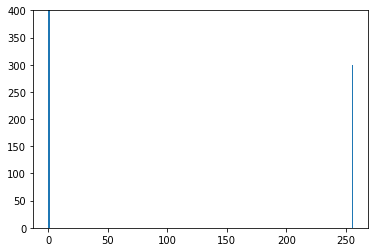

In [ ]:
hist = cv2.calcHist([left11], [0], None, [256], [0, 256])
plt.ylim(0,400)
plt.hist(left11.ravel(), 256, [0, 256]);

In [ ]:
hist_left.mean()

23.222656

In [ ]:
thresh_y = (hist_left.mean() + 255) / 2
r, t = np.where(left11>thresh_y)
r, t

(array([ 0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,  4,
         4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  7,  7,  7,  7,
         7,  7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10,
        10, 10, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 13,
        13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
        17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18,
        18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20,
        21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
        22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 24,
        24, 